# 问题
$-u^{''}(x)=f(x), u(0)=u(1)=0$

其中
$f(x) = -(2\cos x-(x-1)\sin x)$

真解
$u(x) = x\sin x$

In [274]:
import numpy as np

# 划分网格
N = 100
x0 = 0
x1 = 1 
x = np.linspace(x0, x1, N+2) # cell edges
# xc = (x[1:] + x[:-1]) / 2   # cell centers

global dx
dx = x[1] - x[0]

In [275]:
# 计算a(phi_i, phi_j)  
def a(phi1:int, phi2:int):
    if phi1 == phi2:
        return 2.0 / dx
    elif phi1 == phi2 + 1:
        return -1.0 / dx
    elif phi1 == phi2 - 1:
        return -1.0 / dx
    else:
        return 0


def f(x):
    return -(2*np.cos(x) - (x-1)*np.sin(x))

# 计算F(phi_i)
def F(phi:int):
    return f(x[phi]) * dx  #高斯积分

In [276]:
A = np.zeros((N, N))
B = np.zeros(N)
for i in range(N):
    for j in range(N):
        A[i, j] = a(i, j)
    B[i] = F(i)

In [277]:
k = np.linalg.solve(A, B)

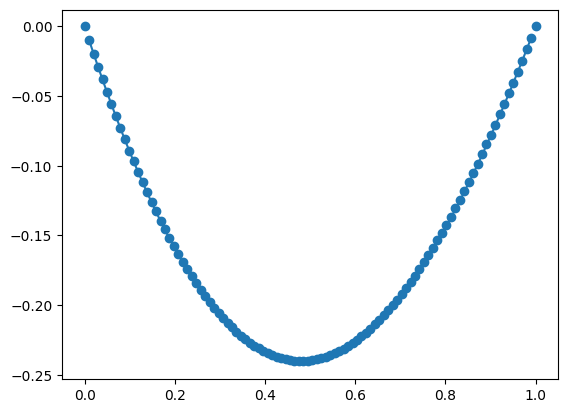

In [278]:
u_real = (x - 1) * np.sin(x)

import matplotlib.pyplot as plt
plt.plot(x[1:-1], k)
plt.scatter(x, u_real)
plt.show()

# DG
$$\frac{\partial{u}}{\partial{t}} + \frac{\partial{u}}{\partial{x}} = 0, \quad u(x,0) = \sin x$$

In [279]:
def get_GLP(NumGLP): # 获取高斯积分点和权重
    if(NumGLP == 5):
        point = np.array([-0.9061798459386640, -0.5384693101056831 ,0, 0.5384693101056831 , 0.9061798459386640])
        weight = np.array([0.2369268850561891, 0.4786286704993665, 0.5688888888888889,  0.4786286704993665,  0.2369268850561891])
        return point, weight

In [280]:
Nx = 100
k= 2 # 多项式阶数
NumGLP = 2*k + 1 # 高斯积分点数
dimPk = k + 1 # Pk空间维数
CFL = 0.1

xa = 0
xb = 2 * np.pi
bcL = 1
bcR = 1
t_end = 2 * np.pi

hx = (xb - xa) / Nx
h1 = hx / 2

x = np.linspace(xa, xb, Nx+1)
xc = np.linspace(xa + h1, xb - h1, Nx)

In [281]:
def u0(x):
    if x > np.pi/2 and x < 3*np.pi/2:
        return 1
    else:
        return 0

In [282]:
# 计算初值
u_real = np.zeros((Nx, NumGLP)) # Nx个单元，每个单元NumGLP个高斯点
point, weight = get_GLP(NumGLP) 
for i in range(Nx):
    for j in range(NumGLP):
        u_real[i, j] = u0(xc[i] + h1 * point[j])

In [283]:
#基函数在Gauss点和端点的值
phi_Gauss = np.zeros((NumGLP,dimPk))
phi_grad_Gauss = np.zeros((NumGLP,dimPk))
phi_left = np.zeros(dimPk)
phi_right = np.zeros(dimPk)
mass = np.asarray([1, 1/3, 4/45])

# X = (x - xc) / h1
# phi0 = 1
# phi1 = X   
# phi2 = X^2 - 1/3

for i in range(NumGLP):
    phi_Gauss[i,0] = 1
    phi_grad_Gauss[i,0] = 0

    phi_Gauss[i,1] = point[i]
    phi_grad_Gauss[i,1] = 1 / h1

    phi_Gauss[i,2] = point[i] ** 2 - 1/3
    phi_grad_Gauss[i,2] = 2 * point[i] / h1

phi_left[0] = 1; phi_left[1] = -1; phi_left[2] = 2 / 3
phi_right[0] = 1; phi_right[1] = 1; phi_right[2] = 2 / 3

In [284]:
# 获取初值L2投影
uh = np.zeros((Nx, dimPk)) # 基函数系数

for i in range(Nx): # Nx个单元
    for j in range(dimPk): # dimPk个基函数
        for k in range(NumGLP): # NumGLP个高斯点
            uh[i,j] += u_real[i,k] * phi_Gauss[k,j] * weight[k]

for i in range(dimPk):
    uh[:,i] /= 2 * mass[i]

In [285]:
def get_u(uh):
    # u_num = np.zeros((Nx, NumGLP))
    # for i in range(Nx):
    #     for j in range(NumGLP):
    #         for k in range(dimPk):
    #             u_num[i,j] += uh[i,k] * phi_Gauss[j,k]
    u_num = np.dot(uh, phi_Gauss.T)
    return u_num

In [286]:
M = 1
def minmod(a,b,c):
    if abs(a) < M * hx **2:
        return a
    elif np.sign(a) == np.sign(b) and np.sign(b) == np.sign(c):
        return np.sign(a) * min(abs(a), abs(b), abs(c))
    else:
        return 0

In [287]:
def Maximum_Limiter(uh):
    uhGLL = get_u(uh)

    for i in range(Nx):
        theta = 1
        for i1 in range(NumGLP):
            thetaq = np.min(np.abs([ (M - uh[i,0])/(uhGLL[i,i1] - uh[i,0]), (m - uh[i,0])/(uhGLL[i,i1] - uh[i,0]), 1 ]))
            if thetaq < theta:
                theta = thetaq
        uh[i,1:] = uh[i,1:] * theta

    return uh


In [288]:
def TVD_Limiter(uh):
    # bc
    uhb = np.array([np.zeros(dimPk), *uh, np.zeros(dimPk)])
    if bcL == 1:
        uhb[0] = uh[-1]
    if bcR == 1:
        uhb[-1] = uh[0]

    uhmod = np.zeros((Nx,dimPk))
    uhmod[:,0] = uh[:,0]

    for i in range(Nx):
        deltaUR = uh[i,1] + (2/3)*uh[i,2]
        deltaUL = uh[i,1] - (2/3)*uh[i,2]
        deltaURM = uhb[i + 2,0] - uhb[i + 1,0]
        deltaULM = uhb[i + 1,0] - uhb[i,0]
    
        deltaURM1 = minmod(deltaUR,deltaURM,deltaULM)
        deltaULM1 = minmod(deltaUL,deltaURM,deltaULM)
        
        uhmod[i,1] = (deltaURM1 + deltaULM1)/2
        uhmod[i,2] = 3*(deltaURM1 - deltaULM1)/4

    return uhmod



def Lh(uh):
    
    # bc
    uhb = np.array([np.zeros(dimPk), *uh, np.zeros(dimPk)])
    if bcL == 1:
        uhb[0] = uh[-1]
    if bcR == 1:
        uhb[-1] = uh[0]

    # 计算内部积分项
    uh_gauss = get_u(uh)
    weight_matrix = np.diag(weight)

    # du = np.zeros((Nx, dimPk))
    # for i in range(Nx):
    #     for j in range(dimPk):
    #         for k in range(NumGLP):
    #             du[i,j] += 0.5 * weight[k] * uh_gauss[i,k] * phi_grad_Gauss[k,j]

    du = 0.5 * uh_gauss @ weight_matrix @ phi_grad_Gauss  # [i,k] × [k,k] × [k,j] = [i,j]



    # 计算Flux
    uhL = np.zeros(Nx+1)
    uhR = np.zeros(Nx+1)

    for i in range(Nx+1):
        for j in range(dimPk):
            uhR[i] += uhb[i,j] * phi_right[j]
            uhL[i] += uhb[i+1,j] * phi_left[j]

    Flux = np.zeros(Nx+1)

    for i in range(Nx+1):
        uR = uhL[i]
        uL = uhR[i]
        alp = 1
        Flux[i] = 0.5 * (uR + uL - alp * (uR - uL))

    # 计算Lh

    Lh = np.zeros((Nx, dimPk))

    for i in range(Nx):
        for j in range(dimPk):
            Lh[i,j] = du[i,j] - (Flux[i+1] * phi_right[j] - Flux[i] * phi_left[j]) / hx


    for i in range(dimPk):
        Lh[:,i] /= mass[i]

    return Lh

In [289]:
CFL = 0.1
dt = CFL * hx
t = 0

/tmp/ipykernel_28997/4049542414.py:7: RuntimeWarning: divide by zero encountered in scalar divide
  thetaq = np.min(np.abs([ (M - uh[i,0])/(uhGLL[i,i1] - uh[i,0]), (m - uh[i,0])/(uhGLL[i,i1] - uh[i,0]), 1 ]))
/tmp/ipykernel_28997/4049542414.py:7: RuntimeWarning: invalid value encountered in scalar divide
  thetaq = np.min(np.abs([ (M - uh[i,0])/(uhGLL[i,i1] - uh[i,0]), (m - uh[i,0])/(uhGLL[i,i1] - uh[i,0]), 1 ]))


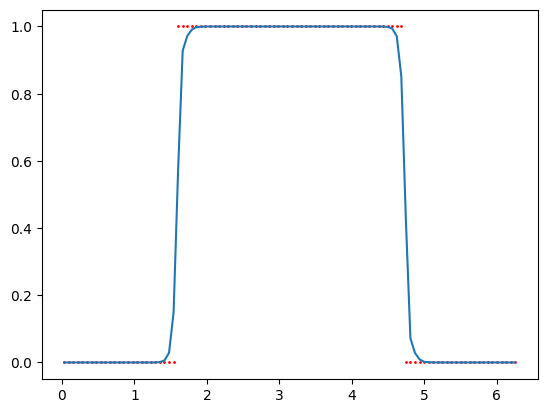

In [290]:
M = 1
m = 0
for i in range(int(2*np.pi/dt)):
    t += dt
    
    delta_u = Lh(uh)
    uh1 = uh + dt * delta_u
    uh1 = Maximum_Limiter(uh1)

    delta_u = Lh(uh1)
    uh2 = 0.75 * uh + 0.25 * (uh1 + dt * delta_u)
    uh2 = Maximum_Limiter(uh2)

    delta_u = Lh(uh2)
    uh = 1/3 * uh + 2/3 * (uh2 + dt * delta_u)
    uh = Maximum_Limiter(uh)

u_num = np.zeros((Nx, NumGLP))
for i in range(Nx):
    for j in range(NumGLP):
        for k in range(dimPk):
            u_num[i,j] += uh[i,k] * phi_Gauss[j,k] # 计算u在高斯点的值

plt.plot(xc, u_num[:,0])
plt.scatter(xc, [u0(x) for x in xc], c='r', s=1)